In [14]:
import sys
import torch
import os
from os import makedirs
from argparse import ArgumentParser
from argparse import Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
import numpy as np
from scene import Scene, GaussianModel
from utils.general_utils import safe_state
import open3d as o3d
from random import randint
from gaussian_renderer import render, network_gui
import matplotlib.pyplot as plt

In [19]:
# Setup Command line Arg
sys.argv = ["train.py", "-s", "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data"
                        "-m" , "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\output\\RGBD_Model"]

parser = ArgumentParser(description='Progressice Gaussian Splatting')
model = ModelParams(parser)
pipeline = PipelineParams(parser)
op = OptimizationParams(parser)

# parser.add_argument('--ip', type=str, default="127.0.0.1")
# parser.add_argument('--port', type=int, default=6009)
# parser.add_argument('--debug_from', type=int, default=-1)
# parser.add_argument('--detect_anomaly', action='store_true', default=False)
# parser.add_argument("--save_iterations", nargs="+", type=int, default=3000)
# parser.add_argument("--test_iterations", nargs="+", type=int, default=3000)
parser.add_argument("--quiet", action="store_true")
# parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=3000)
# parser.add_argument("--start_checkpoint", type=str, default = None)

args = parser.parse_args(sys.argv[1:])

# Initialize system state (RNG)
safe_state(args.quiet)

dataset, iteration, pipeline = model.extract(args), op.extract(args), pipeline.extract(args)

In [20]:
with torch.no_grad():
    # Initialize Gaussians with Zero Tensor
    gaussians = GaussianModel(dataset.sh_degree)

    # Load Actual Gaussians, Camera from PCD
    scene = Scene(dataset, gaussians, shuffle=False)

AssertionError: Could not recognize scene type!

In [9]:
# Pick a random Camera
viewpoint_stack = None

opt = op.extract(args)

if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
# Render
bg = torch.rand((3), device="cuda")

render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)

image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]


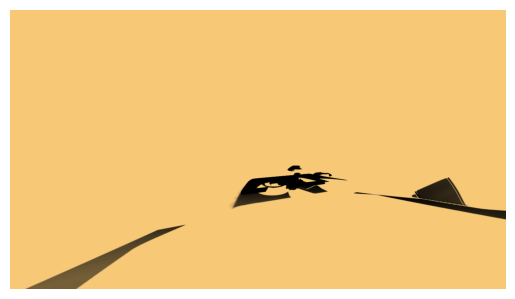

In [17]:
image_numpy = image.cpu().detach().numpy()

# Transpose the dimensions to [height, width, channels]
image_numpy = np.transpose(image_numpy, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [ ]:
# Camera Loader
directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\config"

config_files = os.listdir(directory)
config_files.sort()

for file in config_files[:1]:
    if file.startswith("campose-rgb-"):
        config_file = os.path.join(directory, file)
        print(config_file)
        
        with open(config_file, 'r') as file:
            lines = file.readlines()

            # Extracting position
            position_str = lines[0].replace('position=', '').split('\n')[0]
            position = np.array([float(i) for i in position_str.strip('()').split(',')])

            # Extracting rotation as a quaternion
            rotation_str = lines[1].replace('rotation_as_quaternion=', '').split('\n')[0]
            rotation = np.array([float(i) for i in rotation_str.strip('()').split(',')])

            # Extracting the 4x4 pose matrix
            pose_str = lines[3:]
            pose = np.array([[float(i) for i in row.strip('(').split(')')[0].split(',')] for row in pose_str if row != ''])    

        print(position)
        print(rotation)
        print(pose)

In [18]:
# Directory where your images are stored
directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\rgb"

# Get the list of files in the directory
files = os.listdir(directory)

# Sort the files to process depth and color images together
files.sort()

# Initialize an empty point cloud
point_cloud = o3d.geometry.PointCloud()

# Loop through each pair of depth and color images
for file in files[:1]:
    if file.startswith("gt-rgb-depth-"):  # Check if the file is a depth image
        depth_file = os.path.join(directory, file)
        
        # Get the corresponding color image
        color_file = os.path.join(directory, "rgb-" + file[-8:])  # Assuming both files have corresponding indices
        
        # Read the depth and color images
        depth_image = o3d.io.read_image(depth_file)
        color_image = o3d.io.read_image(color_file)
        
        # Convert images to numpy arrays
        depth_array = np.asarray(depth_image)
        color_array = np.asarray(color_image)

        width = depth_array.shape[1]
        height = depth_array.shape[0]
        
        # Intrinsic parameters of the camera (you may need to adjust these values)
        intrinsic = o3d.camera.PinholeCameraIntrinsic()
        intrinsic.set_intrinsics(width=width, height=height, cx=width / 2, cy=height / 2, fx=500, fy=500)
        
        # Create a point cloud from the depth and color information
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image, depth_image, depth_trunc=4.0, convert_rgb_to_intensity=False)
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
        
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        
        # Merge current point cloud with the overall point cloud
        point_cloud += pcd

# Visualize the final point cloud
o3d.visualization.draw_geometries([point_cloud])


In [ ]:
def readRGBDConfig(config_file):
    # Define dictionaries to hold camera parameters
    rgb_camera_params = {}
    depth_camera_params = {}
    relative_positions = {}
    
    with open(config_file, 'r') as file:
        data = file.read().split('\n\n')
    
        # Read RGB camera parameters
        rgb_data = data[0].split('\n')
        for line in rgb_data[1:4]:
            key, value = line.split('=')
            if ',' in value:
                value = tuple(map(float, value.split(',')))
            else:
                value = tuple(map(int, value.split('x')))
            rgb_camera_params[key] = value

        vFOV, hFOV = rgb_data[4].split(',')
        key, value = vFOV.split('=')
        rgb_camera_params[key] = float(value.strip('°'))
        key, value = hFOV.split('=')
        rgb_camera_params[key.strip(' ')] = float(value.strip('°'))

        # Read Depth camera parameters
        depth_data = data[1].split('\n')
        for line in depth_data[1:4]:
            key, value = line.split('=')
            if ',' in value:
                value = tuple(map(float, value.split(',')))
            else:
                value = tuple(map(int, value.split('x')))
            depth_camera_params[key] = value

        vFOV, hFOV = depth_data[4].split(',')
        key, value = vFOV.split('=')
        depth_camera_params[key] = float(value.strip('°'))
        key, value = hFOV.split('=')
        depth_camera_params[key.strip(' ')] = float(value.strip('°'))

    
        # Read relative positions of camera components
        rel_pos_data = data[2].split('\n')
        for line in rel_pos_data[1:]:
            key, value = line.split(': ')
            value = tuple(map(float, value.strip('(').strip(')').split(',')))
            relative_positions[key] = value

        return rgb_camera_params, depth_camera_params, relative_positions
    
    # Access the loaded camera parameters
    print("RGB Camera Parameters:")
    print(rgb_camera_params)
    
    print("\nDepth Camera Parameters:")
    print(depth_camera_params)
    
    print("\nRelative Positions of Camera Components:")
    print(relative_positions)

conifg = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\config\\configuration.txt"
readRGBDConfig(conifg)